<h1 style="color: #002080; text-align: center;">Titanic Competition</h1>

<h2 style="color: #800000;">1- Import libraries and data</h2>

<h3><li style="color: #808000;">Import libraries:</li></h3>

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')


<h3><li style="color: #808000;">Import data:</li></h3>

In [44]:
train = pd.read_csv("train.csv")
train.name = 'Train Dataset'
test = pd.read_csv("test.csv")
test.name = 'Test Dataset'
combined_set = [train, test]


<h2 style="color: #800000;">2- First Look</h2>

In [45]:
for dataset in [train,test]:
    display(dataset.head(5).style.set_caption("<h2>First 5 rows from "+dataset.name+"</h2>"))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.829200,nan,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.000000,nan,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.687500,nan,Q
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.662500,nan,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.287500,nan,S


<h3><li style="color: #808000;">Data information:</li></h3>

In [46]:
for dataset in [train,test]:
    print('*'*15, dataset.name, '*'*15)
    dataset.info()
    print()

*************** Train Dataset ***************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

*************** Test Dataset ***************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  

In [47]:
for dataset in [train,test]:
    print('*'*25, dataset.name, '*'*25)
    print("The shape of our data is: ", dataset.shape)
    print('Features: ', dataset.columns.values)
    print('The number of duplicated valeus: ',dataset.duplicated().sum())
    print('The total number of missing valeus: ',sum(dataset.isnull().sum()))
    print('The number of missing values in each column:')
    nulls = pd.DataFrame(dataset.isnull().sum().sort_values(ascending=False))
    nulls.columns = ['Null Count']
    nulls.index.name = 'Feature'
    nulls['percent'] = nulls['Null Count']/dataset['PassengerId'].count()
    nulls = nulls[nulls['Null Count']!=0]
    display(nulls)

************************* Train Dataset *************************
The shape of our data is:  (891, 12)
Features:  ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
The number of duplicated valeus:  0
The total number of missing valeus:  866
The number of missing values in each column:


,Null Count,percent
Feature,,
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


************************* Test Dataset *************************
The shape of our data is:  (418, 11)
Features:  ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']
The number of duplicated valeus:  0
The total number of missing valeus:  414
The number of missing values in each column:


,Null Count,percent
Feature,,
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


Let's plot the number of servivers:

<AxesSubplot: xlabel='Survived', ylabel='count'>

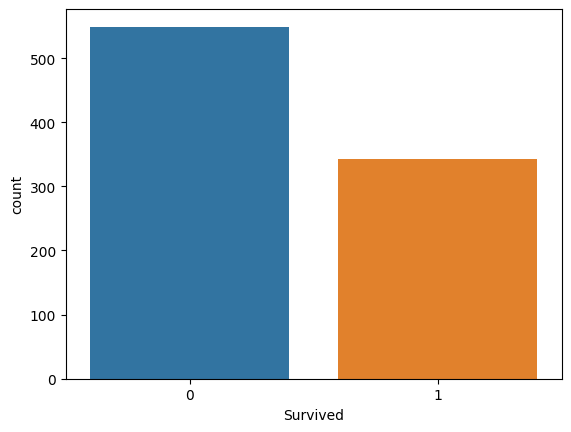

In [48]:
sns.countplot(data=train,x='Survived')

Let's have a look on correlations:

In [49]:
corr = train.corr()
corr["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

And let's have a look in the percent of serviving fpr each class:

In [50]:
for feature in ("Pclass", "Sex", "SibSp", "Parch", "Embarked"):
    print(train[["Survived", feature]].groupby([feature]).mean().sort_values(by="Survived", ascending=False))
    print()

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

        Survived
Sex             
female  0.742038
male    0.188908

       Survived
SibSp          
1      0.535885
2      0.464286
0      0.345395
3      0.250000
4      0.166667
5      0.000000
8      0.000000

       Survived
Parch          
3      0.600000
1      0.550847
2      0.500000
0      0.343658
5      0.200000
4      0.000000
6      0.000000

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957



Last thing to see is the percents of values of each column, that's my help us after:

In [51]:
for feature in train.drop(['PassengerId','Name','Age','Fare','Ticket'],axis=1).columns.values:
    print((train[feature].value_counts(normalize=True) * 100).round(2).astype(str) + " %" )
    print()

0    61.62 %
1    38.38 %
Name: Survived, dtype: object

3    55.11 %
1    24.24 %
2    20.65 %
Name: Pclass, dtype: object

male      64.76 %
female    35.24 %
Name: Sex, dtype: object

0    68.24 %
1    23.46 %
2     3.14 %
4     2.02 %
3      1.8 %
8     0.79 %
5     0.56 %
Name: SibSp, dtype: object

0    76.09 %
1    13.24 %
2     8.98 %
5     0.56 %
3     0.56 %
4     0.45 %
6     0.11 %
Name: Parch, dtype: object

B96 B98        1.96 %
G6             1.96 %
C23 C25 C27    1.96 %
C22 C26        1.47 %
F33            1.47 %
                ...  
E34            0.49 %
C7             0.49 %
C54            0.49 %
E36            0.49 %
C148           0.49 %
Name: Cabin, Length: 147, dtype: object

S    72.44 %
C     18.9 %
Q     8.66 %
Name: Embarked, dtype: object



<p>
From those inforomation, notice that:<br>
<ul>
 <li>More then 60% of passengers didn't servived;</li>
 <br>
 <li>The Name column is more complexe, we can't work with like that;</li>
 <br>
 <li>The available features have following types:
  <ul>
   <li>Numerical - Age, Fare, SibSp, Parch</li>
   <li>Categorical - Survived, Pclass, Sex, Embarked</li>
   <li>Mixed - Ticket, Cabin;</li>
  </ul>
 </li>
 <br>
 <li>Our data is relatively clean with most columns not having null values except for the Cabin, Age, Embarked, and Fare columns;</li>
 <br>
 <li>The correlation shows that:
  <ul>
   <li>The PClass column has highest negative correlation, namely because the lowest class hosted large amount of people and is least favoured to be saved in the incident due to lower privelages from the upper deck.</li>
   <li>Fare has the highest positive correlation. This makes sense, since a higher fare equates to a better class and cabin.</li>
  </ul>
 </li>
 <br>
 <li>There is a unique ticket for each passenger, it gives no info that can helps in predictions. So, we'll delete it</li>
 </ul>
</p>

<h2 style="color: #800000;">3- Feature Engineering</h2>

Befor starting this part, it's better to work with a copy of the data for the case we break something down:

In [52]:
train_copy = train.copy()
test_copy = test.copy()

Let's create a `Age Bucket` for different ranges of `Age`:

In [53]:
train_copy["AgeBucket"] = pd.cut(train_copy["Age"], 6)
train_copy[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean().sort_values(by="AgeBucket")

,Survived
AgeBucket,
"(0.34, 13.683]",0.591549
"(13.683, 26.947]",0.354839
"(26.947, 40.21]",0.428571
"(40.21, 53.473]",0.390000
"(53.473, 66.737]",0.348837
"(66.737, 80.0]",0.142857


In [54]:
train_copy["AgeBucket"] = pd.cut(train_copy["Age"], 6, labels=[1, 2, 3, 4, 5, 6])

Similarly, let's make a `Fare Bucket`:

In [55]:
train_copy["FareBucket"] = pd.cut(train_copy["Fare"], 10)
train_copy[["FareBucket", "Survived"]].groupby(["FareBucket"]).mean().sort_values(by="FareBucket")

,Survived
FareBucket,
"(-0.512, 51.233]",0.318306
"(51.233, 102.466]",0.660377
"(102.466, 153.699]",0.741935
"(153.699, 204.932]",1.000000
"(204.932, 256.165]",0.636364
"(256.165, 307.398]",0.666667
"(307.398, 358.63]",NaN
"(358.63, 409.863]",NaN
"(409.863, 461.096]",NaN


In [56]:
train_copy["FareBucket"] = pd.cut(train_copy["Fare"], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Make a `Relatives Bucket`, this will help to create a new feature - `IsAlone` (indicating if the passenger was alone or had a family)

In [57]:
train_copy["RelativesBucket"] = train_copy["SibSp"] + train_copy["Parch"]
train_copy[["RelativesBucket", "Survived"]].groupby(["RelativesBucket"]).mean().sort_values(by="RelativesBucket")

,Survived
RelativesBucket,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [58]:
train_copy["IsAlone"] = (train_copy["RelativesBucket"] == 0).astype(int)
train_copy[["IsAlone", "Survived"]].groupby(["IsAlone"]).mean().sort_values(by="IsAlone")

,Survived
IsAlone,
0,0.505650
1,0.303538


We can use the `Name` feature for extracting titles of passengers, due to the Name feature has a lot of unique values:

In [59]:
train_copy["Title"] = train_copy["Name"].str.extract(" ([A-Za-z]+)\.")
train_copy["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

Replace uniqe titles with "Unique":

In [60]:
unique_titles = set(train_copy["Title"]).difference({"Mr", "Miss", "Mrs", "Master"})
train_copy["Title"] = train_copy["Title"].replace(unique_titles, "Unique")
train_copy["Title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Unique     27
Name: Title, dtype: int64

In [61]:
train_copy[["Title", "Survived"]].groupby(["Title"]).mean().sort_values(by="Title")

,Survived
Title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
Unique,0.444444


<h2 style="color: #800000;">4- Preprocessing</h2>

This class we'll contains all previous steps and some other steps, so we can preprocessing the data easly:

In [62]:
class AttributeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, add_age_bucket=True, add_fare_bucket=True, add_is_alone=True, add_title=True,
                remove_cabin=True, remove_ticket=True):
        self.add_age_bucket = add_age_bucket
        self.add_fare_bucket = add_fare_bucket
        self.add_is_alone = add_is_alone
        self.add_title = add_title
        self.remove_cabin = remove_cabin
        self.remove_ticket = remove_ticket
    
    def fit(self, X, y=None):
        self.age_median = X["Age"].median()
        self.fare_median = X["Fare"].median()
        self.most_frequent_embark = X["Embarked"].value_counts().index[0]
        return self

    def transform(self, X):
        X["Age"] = X["Age"].fillna(self.age_median)
        X["Fare"] = X["Fare"].fillna(self.fare_median)
        X["Embarked"] = X["Embarked"].fillna(self.most_frequent_embark)
        if self.add_age_bucket:
            X["AgeBucket"] = pd.cut(X["Age"], 5, labels=[1, 2, 3, 4, 5])
            X.drop(["Age"], axis=1, inplace=True)
        if self.add_fare_bucket:
            X["FareBucket"] = pd.cut(X["Fare"], 5, labels=[1, 2, 3, 4, 5])
            X.drop(["Fare"], axis=1, inplace=True)
        if self.add_is_alone:
            X["IsAlone"] = (X["SibSp"] + X["Parch"] == 0).astype(int)
            X.drop(["SibSp", "Parch"], axis=1, inplace=True)
        if self.add_title:
            X["Title"] = X["Name"].str.extract(" ([A-Za-z]+)\.")
            unique_titles = set(X["Title"]).difference({"Mr", "Miss", "Mrs", "Master"})
            X["Title"] = train_copy["Title"].replace(unique_titles, "Unique")
            X.drop(["Name"], axis=1, inplace=True)
        if self.remove_cabin:
            X.drop(["Cabin"], axis=1, inplace=True)
        if self.remove_ticket:
            X.drop(["Ticket"], axis=1, inplace=True)
        return X

<h3><li style="color: #808000;">Preprocessing the Train Data:</li></h3>

In [63]:
attr_pipeline = Pipeline([
    ("attr_imputer_transformer", AttributeImputer())
])

tmp_train = train.copy()
tmp_train = attr_pipeline.fit_transform(tmp_train)
tmp_train.head()

,PassengerId,Survived,Pclass,Sex,Embarked,AgeBucket,FareBucket,IsAlone,Title
0,1,0,3,male,S,2,1,0,Mr
1,2,1,1,female,C,3,1,0,Mrs
2,3,1,3,female,S,2,1,1,Miss
3,4,1,1,female,S,3,1,0,Mrs
4,5,0,3,male,S,3,1,1,Mr


<h3><li style="color: #808000;">Features encoding:</li></h3>

In [64]:
cat_pipeline = Pipeline([
    ("cat_encoder", OneHotEncoder(sparse=False))
])

cat_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, ["Pclass", "Sex", "Embarked", "AgeBucket", "FareBucket", "IsAlone", "Title"])
])

preproc_pipeline = Pipeline([
    ("attrs_pipline", attr_pipeline),
    ("cats_pipeline", cat_pipeline)
])

In [65]:
tmp_train = train.copy()
tmp_train = tmp_train.set_index("PassengerId")
tmp_train_labels = tmp_train["Survived"]
tmp_train.drop("Survived", axis=1, inplace=True)
tmp_train = preproc_pipeline.fit_transform(tmp_train)

<h2 style="color: #800000;">5- Modeling</h2>

For this problem, we'll use one of: `RandomForestClassifier`, `SGDClassifier`, `SVC`, `DecisionTreeClassifier`, `LogisticRegression`:

In [66]:
forest_model = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_model, tmp_train, tmp_train_labels, cv=10)
forest_scores.mean()

0.7946566791510611

In [67]:
sgd_model = SGDClassifier(random_state=42)
sgd_scores = cross_val_score(sgd_model, tmp_train, tmp_train_labels, cv=10)
sgd_scores.mean()

0.7789388264669163

In [68]:
svm_model = SVC(random_state=42)
svm_scores = cross_val_score(svm_model, tmp_train, tmp_train_labels, cv=10)
svm_scores.mean()

0.8192883895131086

In [69]:
tree_model = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_model, tmp_train, tmp_train_labels, cv=10)
tree_scores.mean()

0.7946441947565542

In [70]:
log_model = LogisticRegression()
log_scores= cross_val_score(log_model, tmp_train, tmp_train_labels, cv=10)
log_scores.mean()

0.7935205992509362

We are looking for best parameters:

<h4><li style="color: #808000;">Random Forest:</li></h4>

In [71]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_model = RandomForestClassifier(random_state=42)
grid_search_rfc = GridSearchCV(forest_model, param_grid, cv=10, scoring="accuracy")
grid_search_rfc.fit(tmp_train, tmp_train_labels)
print(grid_search_rfc.best_score_)
print(grid_search_rfc.best_params_)

0.8047565543071162
{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}


<h4><li style="color: #808000;">SVM:</li></h4>

In [72]:
param_grid = [{
    "C": [0.3, 1, 3],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
    "decision_function_shape": ["ovo", "ovr"],
}]

svm_model = SVC(random_state=42)
grid_search_svc = GridSearchCV(svm_model, param_grid, cv=10, scoring="accuracy")
grid_search_svc.fit(tmp_train, tmp_train_labels)
print(grid_search_svc.best_score_)
print(grid_search_svc.best_params_)

0.8215605493133582
{'C': 3, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


<h4><li style="color: #808000;">Logistic Regression:</li></h4>

In [73]:
param_grid = [{
    'penalty': ['l1', 'l2' , 'elasticnet'], 
    'C': np.logspace(0, 2, 10),
    'max_iter': [300,400,500,800]
}]

log_model = LogisticRegression(random_state=42)
grid_search_log = GridSearchCV(log_model, param_grid, cv=10, scoring="accuracy")
grid_search_log.fit(tmp_train, tmp_train_labels)
print(grid_search_log.best_score_)
print(grid_search_log.best_params_)

0.7957677902621723
{'C': 1.6681005372000588, 'max_iter': 300, 'penalty': 'l2'}


<h2 style="color: #800000;">6- Last Step</h2>

The best model out of these is the `SVC`, and we'll use it in this last step to predict the `Test Dataset`:

In [74]:
svm_final = SVC(random_state=42, **grid_search_svc.best_params_)
svm_final.fit(tmp_train, tmp_train_labels)

SVC(C=3, decision_function_shape='ovo', random_state=42)

In [75]:
tmp_test = pd.read_csv("test.csv")
idx = tmp_test["PassengerId"]
tmp_test = tmp_test.set_index("PassengerId")
tmp_test = preproc_pipeline.transform(tmp_test)

results = svm_final.predict(tmp_test)
df = pd.DataFrame({"PassengerId": idx, "Survived": results})
df.set_index("PassengerId").to_csv("submission5.csv")
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
